1. 전복 분류를 CNN으로 구현하고

2. 모델을 저장한 후에,

3. 사전학습 모델로 불러서 새로운 층과 출력층을 추가하고

4. 미세조정 fine-tunning

# 전복 데이터 불러오기 및 데이터 전처리

In [33]:
import pandas as pd

data = pd.read_csv('abalone.csv')
data.head()

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


데이터 안에 어떤 열이 있고 행의 갯수는 몇 개 인지 파악

In [34]:
data.info()

# 모든 행이 non_null로 이상치는 없는거 같다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4177 non-null   int64  
 1   Sex             4177 non-null   object 
 2   Length          4177 non-null   float64
 3   Diameter        4177 non-null   float64
 4   Height          4177 non-null   float64
 5   Whole_weight    4177 non-null   float64
 6   Shucked_weight  4177 non-null   float64
 7   Viscera_weight  4177 non-null   float64
 8   Shell_weight    4177 non-null   float64
 9   Rings           4177 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 326.5+ KB


전복에 대한 분류를 크게 Ring을 기준으로 삼아 나이를 분류할것인지
Sex를 기준으로 삼아 성별을 분류 할 것인지로 나눌 수 있을 것같다.

Rings 를 기준으로 삼아 나이를 분류해보기

In [35]:
# 데이터의 최대 최소 평균 값을 찾아서 데이터가 고르게 나눠질 수 있도록 범위를 조절

min=data['Rings'].min()
max=data['Rings'].max()
mean = data['Rings'].mean()

print(f"Min ; {min}, Max : {max}, mean : {mean}")

Min ; 1, Max : 29, mean : 9.933684462532918


생물학적 기준을 고려하면 0~ 7 살을 어린 전복(Young), 8~12 살을 성장기 전복(Middle) ,13살 이상(Old) 을 성숙한 전복이라고 한다. 따라서 이 기준에 맞게 분류를 수행한다.

In [36]:
# 전복 나이를 카테고리로 나누기
data['Age'] = pd.cut(data['Rings'], bins=[0, 7, 12, 30], labels=['Young', 'Middle', 'Old'])


In [37]:
age_category_counts = data['Age'].value_counts()
print(age_category_counts)

Age
Middle    2645
Young      839
Old        693
Name: count, dtype: int64


입력데이터와 타겟 데이터로 나누기

In [38]:
input = data.drop(['Age','Rings','id'],axis=1)
target = data['Age']

target data 가 category 이므로 label을 LabelEncoder 를 통해 수치형 데이터로 바꿔준다

In [39]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
target = le.fit_transform(target)


input data 에도 'sex' 열이 수치 데이터가 아니므로 원-핫 인코딩으로 바꿔준다

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
input = np.array(ct.fit_transform(input))

In [41]:
print(input)

[[0.     0.     1.     ... 0.2245 0.101  0.15  ]
 [0.     0.     1.     ... 0.0995 0.0485 0.07  ]
 [1.     0.     0.     ... 0.2565 0.1415 0.21  ]
 ...
 [0.     0.     1.     ... 0.5255 0.2875 0.308 ]
 [1.     0.     0.     ... 0.531  0.261  0.296 ]
 [0.     0.     1.     ... 0.9455 0.3765 0.495 ]]


데이터 전처리

In [42]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
input = sc.fit_transform(input)

In [43]:
input.shape

(4177, 10)

현재 input 차원은 (4177,10) 인데 CNN 모델은 최소 3차원 데이터 부터 입력데이터로 들어가야함
Conv1D는 (batch_size,length,channels)가 필요하니깐 차원 하나를 늘려준다

In [44]:
input= np.expand_dims(input,axis=-1)
input.shape

(4177, 10, 1)

In [45]:
target.shape

(4177,)

In [101]:
from sklearn.model_selection import train_test_split

x_train,x_test, y_train, y_test = train_test_split (input,target, test_size=0.2,stratify=target)

# 1. CNN 모델 구성

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv1D(32,kernel_size=3,activation='relu',input_shape=(10,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 8, 32)               │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,027 (66.51 KB)

 Trainable params: 17,027 (66.51 KB)

 Non-trainable params: 0 (0.00 B)

target 이 0 1 2의 정수형 데이터이므로 sparse_categorical_crossentropy 사용

In [48]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [49]:
history = model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test))

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6673 - loss: 0.7884 - val_accuracy: 0.7333 - val_loss: 0.5918
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7436 - loss: 0.6088 - val_accuracy: 0.7488 - val_loss: 0.5828
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7641 - loss: 0.5645 - val_accuracy: 0.7703 - val_loss: 0.5536
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7635 - loss: 0.5528 - val_accuracy: 0.7632 - val_loss: 0.5531
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7618 - loss: 0.5533 - val_accuracy: 0.7715 - val_loss: 0.5524
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7743 - loss: 0.5390 - val_accuracy: 0.7727 - val_loss: 0.5550
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7604 - loss: 0.5565 - val_accuracy: 0.7727 - val_loss: 0.5425
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7707 - loss: 0.5373 - val_accu

loss 시각화

In [50]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

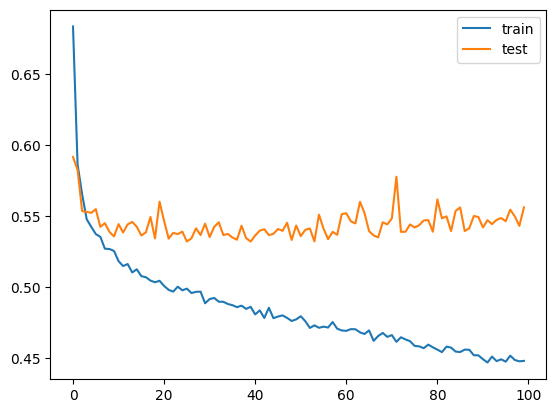

In [51]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()

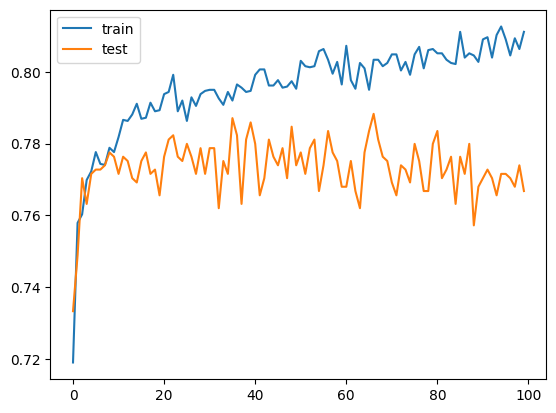

In [52]:
plt.plot(history.history["accuracy"],label="train")
plt.plot(history.history["val_accuracy"],label="test")
plt.legend()

In [53]:
model.evaluate(x_test,y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7768 - loss: 0.5386 


[0.5562352538108826, 0.7667464017868042]

In [54]:
model.evaluate(x_train,y_train)

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8100 - loss: 0.4372


[0.446335107088089, 0.8066447377204895]

# 2. 사전 학습 모델로 저장하기

In [55]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [56]:
import tensorflow as tf

base_loss,base_accuracy=model.evaluate(x_test, y_test)

model_file='/content/drive/MyDrive/abalone.h5'

tf.keras.models.save_model(model, model_file, include_optimizer=False)
print('model saved at ', model_file)
#score,keras_file=evaluate_model(trainX,trainy,testX,testy)
score=base_accuracy*100
print('Accuracy >{:f}'.format(score))
print('Base Loss >{:.2f}'.format(base_loss))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7768 - loss: 0.5386 


model saved at  /content/drive/MyDrive/abalone.h5
Accuracy >76.674640
Base Loss >0.56


# 3. 사전 학습 모델 불러와서 새로운 층과 출력층 추가하기

In [57]:
from tensorflow.keras.models import load_model

base_model = load_model(model_file)

In [58]:
base_model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
base_model.evaluate(x_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7768 - loss: 0.5386  


[0.5562352538108826, 0.7667464017868042]

In [59]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  5


In [82]:
from tensorflow.keras import layers, models

def remove_last_layers(model, num_layers_to_remove):
    # 모델의 레이어를 하나씩 슬라이스해서 앞의 레이어만 가져옴
    model_layers = model.layers[:-num_layers_to_remove]  # 마지막 레이어부터 지정된 갯수만큼 제외
    new_model = models.Sequential(model_layers)  # 새로운 모델에 해당 레이어들만 추가
    return new_model

In [106]:
# 출력층부터 1개의 레이어를 삭제
new_model = remove_last_layers(base_model, 3)

In [107]:
new_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 8, 32)               │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 32)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128 (512.00 B)

 Trainable params: 128 (512.00 B)

 Non-trainable params: 0 (0.00 B)

In [85]:
# 새로운 층으로 Conv1D 층과 Dense층 추가하고 출력층 추가

new_model.add(Conv1D(64,kernel_size=3,activation='relu'))
new_model.add(MaxPooling1D(pool_size=2))
new_model.add(Flatten())
new_model.add(Dense(64,activation='relu'))
new_model.add(Dense(3,activation='softmax'))

In [86]:
new_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
new_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 8, 32)               │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128 (512.00 B)

 Trainable params: 128 (512.00 B)

 Non-trainable params: 0 (0.00 B)

In [87]:
history2 = new_model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test))

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7033 - loss: 0.7543 - val_accuracy: 0.7356 - val_loss: 0.5966
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7525 - loss: 0.5711 - val_accuracy: 0.7703 - val_loss: 0.5576
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7784 - loss: 0.5347 - val_accuracy: 0.7548 - val_loss: 0.5574
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7854 - loss: 0.5067 - val_accuracy: 0.7751 - val_loss: 0.5481
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7704 - loss: 0.5356 - val_accuracy: 0.7715 - val_loss: 0.5362
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7896 - loss: 0.5019 - val_accuracy: 0.7763 - val_loss: 0.5440
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7751 - loss: 0.5297 - val_accuracy: 0.7787 - val_loss: 0.5378
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7890 - loss: 0.5077 - val_accu

바로 과대적합 되어 버림

In [88]:
new_model.evaluate(x_test,y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7435 - loss: 0.6500 


[0.6391223669052124, 0.7464115023612976]

In [89]:
new_model.evaluate(x_train,y_train)

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8551 - loss: 0.3333


[0.34431591629981995, 0.8515414595603943]

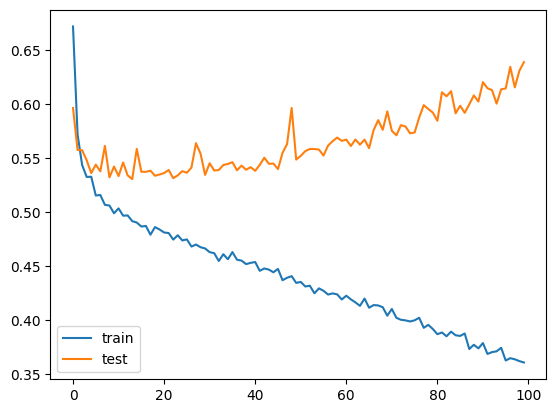

In [90]:
plt.plot(history2.history["loss"], label = "train")
plt.plot(history2.history["val_loss"], label = "test")
plt.legend()

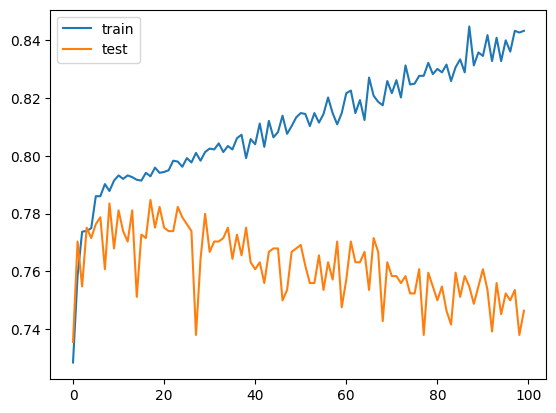

In [91]:
plt.plot(history2.history["accuracy"],label="train")
plt.plot(history2.history["val_accuracy"],label="test")
plt.legend()

# 4. Fine tunning

In [92]:
base_model.trainable = True


In [95]:
new_model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
import pandas as pd
display_layers = [(layer, layer.name, layer.trainable) for layer in new_model.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,"<Conv1D name=conv1d_1, built=True>",conv1d_1,True
1,"<MaxPooling1D name=max_pooling1d_1, built=True>",max_pooling1d_1,True
2,"<Conv1D name=conv1d_4, built=True>",conv1d_4,True
3,"<MaxPooling1D name=max_pooling1d_4, built=True>",max_pooling1d_4,True
4,"<Flatten name=flatten_4, built=True>",flatten_4,True
5,"<Dense name=dense_11, built=True>",dense_11,True
6,"<Dense name=dense_12, built=True>",dense_12,True


In [102]:
history3 = new_model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test),shuffle=True)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8392 - loss: 0.4634 - val_accuracy: 0.8517 - val_loss: 0.4136
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8630 - loss: 0.3878 - val_accuracy: 0.8720 - val_loss: 0.3561
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8511 - loss: 0.3837 - val_accuracy: 0.8361 - val_loss: 0.3786
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8757 - loss: 0.3278 - val_accuracy: 0.8636 - val_loss: 0.3825
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8657 - loss: 0.3139 - val_accuracy: 0.8589 - val_loss: 0.3930
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8796 - loss: 0.3103 - val_accuracy: 0.8624 - val_loss: 0.3942
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8824 - loss: 0.3286 - val_accuracy: 0.8529 - val_loss: 0.4007
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8751 - loss: 0.3109 - val_accu

In [103]:
new_model.evaluate(x_test,y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7616 - loss: 0.7277 


[0.7020605802536011, 0.7882775068283081]

In [104]:
new_model.evaluate(x_train,y_train)

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9276 - loss: 0.1633


[0.16325099766254425, 0.9311583638191223]

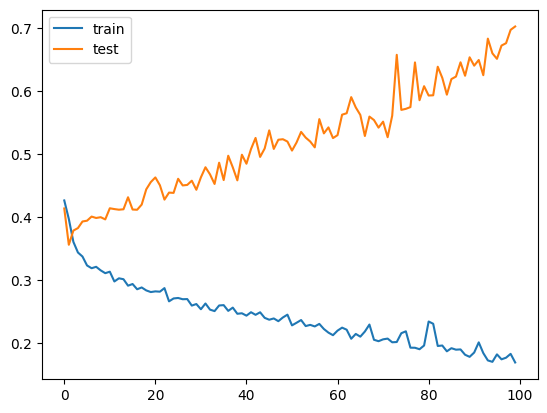

In [105]:
plt.plot(history3.history["loss"], label = "train")
plt.plot(history3.history["val_loss"], label = "test")
plt.legend()

Dropout, BatchNormalization 추가

In [108]:
from tensorflow.keras.layers import Dropout, BatchNormalization

new_model.add(Dropout(0.5))
new_model.add(Conv1D(64,kernel_size=3,activation='relu'))
new_model.add(BatchNormalization())
new_model.add(MaxPooling1D(pool_size=2))
new_model.add(Dropout(0.5))

new_model.add(Flatten())
new_model.add(Dense(64,activation='relu'))
new_model.add(BatchNormalization())
new_model.add(Dropout(0.5))
new_model.add(Dense(3,activation='softmax'))

new_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 8, 32)               │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128 (512.00 B)

 Trainable params: 128 (512.00 B)

 Non-trainable params: 0 (0.00 B)

In [109]:
new_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [110]:
history4 = new_model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test),shuffle=True)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3997 - loss: 1.6697 - val_accuracy: 0.7333 - val_loss: 0.7201
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5584 - loss: 1.0565 - val_accuracy: 0.7213 - val_loss: 0.6722
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6306 - loss: 0.9136 - val_accuracy: 0.7285 - val_loss: 0.6571
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6599 - loss: 0.8078 - val_accuracy: 0.7297 - val_loss: 0.6424
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6973 - loss: 0.7648 - val_accuracy: 0.7297 - val_loss: 0.6419
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6798 - loss: 0.7403 - val_accuracy: 0.7309 - val_loss: 0.6323
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7035 - loss: 0.7028 - val_accuracy: 0.7368 - val_loss: 0.6219
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7073 - loss: 0.7260 - val_accu

In [114]:
new_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 8, 32)               │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 2, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,099 (129.30 KB)

 Trainable params: 10,947 (42.76 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 21,896 (85.54 KB)

In [111]:
new_model.evaluate(x_test,y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7691 - loss: 0.5430


[0.5219433903694153, 0.7763158082962036]

In [112]:
new_model.evaluate(x_train,y_train)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7890 - loss: 0.5033


[0.5177848935127258, 0.7809039354324341]

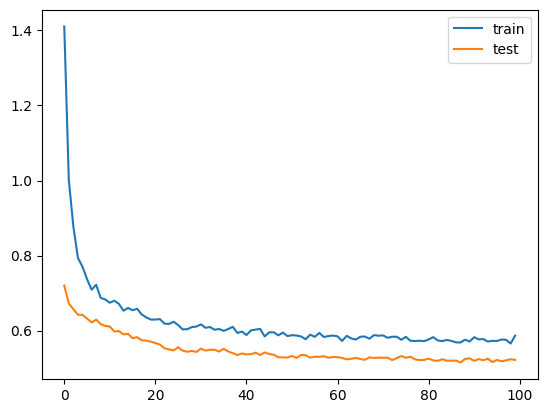

In [113]:
plt.plot(history4.history["loss"], label = "train")
plt.plot(history4.history["val_loss"], label = "test")
plt.legend()

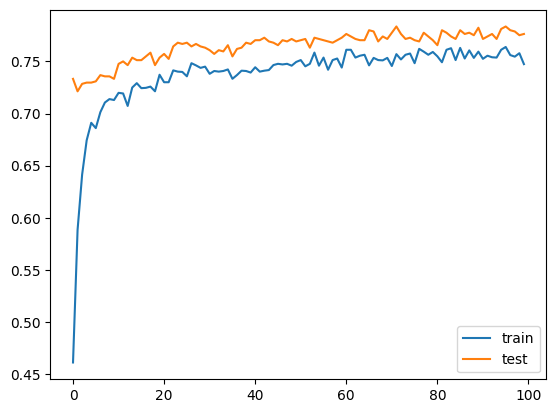

In [115]:
plt.plot(history4.history["accuracy"],label="train")
plt.plot(history4.history["val_accuracy"],label="test")
plt.legend()

## 5. 결론

1. 데이터가 불균형 해 보임

    Middle    2645
    Young      839
    Old        693

2. 모델이 너무 복잡한 거 같다.

3. 드롭아웃층과 배치정규화 층 추가 및 미세 조정으로

 테스트 세트 정확도 0.76 훈련 세트 정확도 0.78 을 달성하여 어느정도 일반화된 모델을 만들긴 함

4. 전체적으로 만족할 만한 정확도는 아니다. CNN 모델에서 차원을 하나 더 늘려 Conv2D 층을 활용해보거나, CNN 모델이 아닌 다른 일반적인 머신러닝 모델, 신경망 모델로 하는 것도 좋은 방법 인 것 같다.